In [2]:

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CyclicLR
import torchvision.utils as vutils
from torchvision import models
from torch.nn import BCELoss
import torch.nn as nn
import torch.nn.functional as F
from torch import sigmoid
from torchvision.models import vgg16

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import cv2


In [17]:
# Use GPU if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Images

In [3]:
# Link to google drive
from google.colab import drive
drive.mount('/content/data')

# mkdir for images
!mkdir /content/data/MyDrive/"Colab Notebooks"/Images
!mkdir /content/data/MyDrive/"Colab Notebooks"/Images/cartoon
!mkdir /content/data/MyDrive/"Colab Notebooks"/Images/smoothed_cartoon
!mkdir /content/data/MyDrive/"Colab Notebooks"/Images/photo

Mounted at /content/data
mkdir: cannot create directory ‘/content/data/MyDrive/Colab Notebooks/Images’: File exists
mkdir: cannot create directory ‘/content/data/MyDrive/Colab Notebooks/Images/cartoon’: File exists
mkdir: cannot create directory ‘/content/data/MyDrive/Colab Notebooks/Images/smoothed_cartoon’: File exists
mkdir: cannot create directory ‘/content/data/MyDrive/Colab Notebooks/Images/photo’: File exists


In [4]:
# Change these images path if needed 
path_to_cartoon = '/content/data/MyDrive/Colab Notebooks/Images/cartoon'
path_to_smoothed_cartoon = '/content/data/MyDrive/Colab Notebooks/Images/smoothed_cartoon'
path_to_photo = '/content/data/MyDrive/Colab Notebooks/Images/photo'

In [29]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split


image_size = 256
batch_size = 16

transformer = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])

torch.manual_seed(1314520)
cartoon_dataset = ImageFolder(path_to_cartoon, transformer)
cartoon_dataloader = DataLoader(cartoon_dataset, batch_size, shuffle=False, num_workers=0)

smoothed_cartoon_dataset = ImageFolder(path_to_smoothed_cartoon, transformer)
smoothed_cartoon_dataloader = DataLoader(smoothed_cartoon_dataset, batch_size, shuffle=False, num_workers=0)

photo_dataset = ImageFolder(path_to_photo, transformer)
photo_dataloader = DataLoader(photo_dataset, batch_size, shuffle=False, num_workers=0)


## Original cartoon image

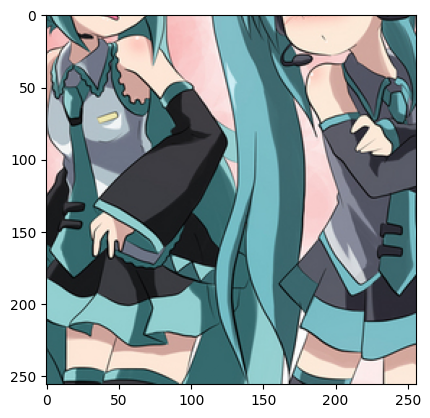

In [24]:
iterator = iter(cartoon_dataloader)
it = next(iterator)
first_sample_image_of_batch = it[0][1]
plt.imshow(np.transpose(first_sample_image_of_batch.numpy(), (1, 2, 0)))

## Smoothed edges cartoon image

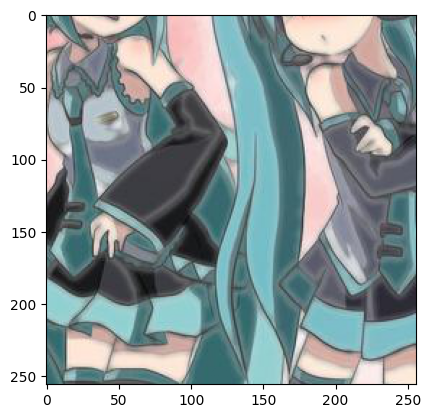

In [25]:
iterator = iter(smoothed_cartoon_dataloader)
it = next(iterator)
first_sample_image_of_batch = it[0][1]
plt.imshow(np.transpose(first_sample_image_of_batch.numpy(), (1, 2, 0)))

# Models

# Generator

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(256)
        
    def forward(self, x):
      ES = x
      x = self.conv1(x)
      x = self.norm1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = self.norm2(x)
      return x + ES

In [9]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    num_residual_blocks = 8

    #k7n64s1
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
    self.norm1 = nn.BatchNorm2d(64)
    
    # Down-convolution
    # k3n128s2, k3n128s1
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.norm2 = nn.BatchNorm2d(128)

    # k3n256s2, k3n256s1
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.norm3 = nn.BatchNorm2d(256)
    
    # residual blocks
    # k3n256s1, k3n256s1
    self.residual_blocks = nn.Sequential(*[ResidualBlock() for i in range(num_residual_blocks)])

    
    # Up-convolution
    # k3n128s1/2, k3n128s1
    self.conv6 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.conv7 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.norm4 = nn.BatchNorm2d(128)


    #k3n64s1/2, k3n64s1
    self.conv8 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.conv9 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.norm5 = nn.BatchNorm2d(64)
    
    # k7n3s1
    self.conv10 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3)

  def forward(self, x):
    x = self.conv1(x)
    x = self.norm1(x)
    x = F.relu(x)

    # Down-convolution
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.norm2(x)
    x = F.relu(x)

    x = self.conv4(x)
    x = self.conv5(x)
    x = self.norm3(x)
    x = F.relu(x)

    # Residual blocks
    x = self.residual_blocks(x)

    # Up-convolution
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.norm4(x)
    x = F.relu(x)

    x = self.conv8(x)
    x = self.conv9(x)
    x = self.norm5(x)
    x = F.relu(x)

    x = self.conv10(x)

    return x


## Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # k3n32s1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        #k3n64s2, k3n128s1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(128)

        #k3n128s2, k3n256s1
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(256)

        #k3n256s1
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(256)

        #k3n1s1
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # k3n32s1
        x = self.conv1(x)
        x = F.leaky_relu(x)

        #k3n64s2, k3n128s1
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)

        #k3n128s2, k3n256s1
        x = self.conv4(x)
        x = F.leaky_relu(x)
        x = self.conv5(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)

        #k3n256s1
        x = self.conv6(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        
        #k3n1s1
        x = self.conv7(x)
        x = sigmoid(x)

        return x

# Loss function
$L(G, D) = L_{adv}(G, D) + wL_{con}(G, D)$

In [18]:
class AdversialLoss(nn.Module):
    def __init__(self):
        super(AdversialLoss, self).__init__()
        self.BCE_log_loss = nn.BCEWithLogitsLoss()

    def forward(self, cartoon, smoothed_cartoon, generated):
        ones = torch.ones (batch_size, 1, image_size // 4, image_size // 4).to(device)
        zeros = torch.zeros (batch_size, 1, image_size // 4, image_size // 4).to(device)
        cartoon_loss = self.BCE_log_loss(cartoon, ones)
        smoothed_cartoon_loss = self.BCE_log_loss(generated, zeros)
        generated_loss = self.BCE_log_loss(smoothed_cartoon, zeros)

        return cartoon_loss + smoothed_cartoon_loss + generated_loss
        

class ContentLoss(nn.Module):
    def __init__(self, w=1):
        super(ContentLoss, self).__init__()

        self.l1_loss = nn.L1Loss()
        self.w = w

        perception = list(vgg16(pretrained=True).features)[:25]
        self.perception = nn.Sequential(*perception).eval()
        for param in self.perception.parameters():
            param.requires_grad = False

    def forward(self, x1, x2):
        x1 = self.perception(x1)
        x2 = self.perception(x2)
        
        return self.w * self.l1_loss(x1, x2)

# Training

In [19]:
#=======================================#
# Parameters
#=======================================#

learning_rate = 1.0e-4
beta1 = 0.5
beta2 = 0.99
weight_decay = 1.0e-4

con_loss_w = 10
epochs = 5
#=======================================#
# Generator and Discriminator
#=======================================#
D = Discriminator().to(device)
G = Generator().to(device)

#=======================================#
# Optimizer
#=======================================#
D_opt = AdamW(D.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)
G_opt = AdamW(G.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)
D_scheduler = CyclicLR(optimizer=D_opt, base_lr=learning_rate, max_lr=learning_rate*1e1, cycle_momentum=False)
G_scheduler = CyclicLR(optimizer=G_opt, base_lr=learning_rate, max_lr=learning_rate*1e1, cycle_momentum=False)

#=======================================#
# Loss functions
#=======================================#
L_adv = AdversialLoss().to(device)
L_con = ContentLoss(con_loss_w).to(device)
BCE_loss = nn.BCELoss().to(device)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
D_losses = []
G_losses = []


for epoch in range(epochs):
    photo_iter = iter(photo_dataloader)
    cartoon_iter = iter(cartoon_dataloader)
    smoothed_cartoon_iter = iter(smoothed_cartoon_dataloader)
    iterations =  min(len(photo_iter), len(cartoon_iter), len(smoothed_cartoon_dataloader))
    for i in range(iterations):

        photo, _ = next(photo_iter)
        cartoon, _ = next(cartoon_iter)
        smoothed_cartoon, _ = next(smoothed_cartoon_iter)

        photo = photo.to(device)
        cartoon = cartoon.to(device)
        smoothed_cartoon = smoothed_cartoon.to(device)

        #================#
        # Train D
        #================#
        D.train()
        G.eval()
        D.zero_grad()

        # Get prediction from D
        cartoon_pred = D(cartoon)
        smoothed_cartoon_pred = D(smoothed_cartoon)
        generated_pred = D(G(photo))

        # Calculate D_loss
        D_loss = L_adv(cartoon_pred, smoothed_cartoon_pred, generated_pred)
        D_loss.backward()
        
        # Update D
        D_opt.step()

        #================#
        # Train G
        #================#
        G.train()
        D.eval()
        G.zero_grad()

        generated_img = G(photo)
        generated_pred = D(generated_img)
        
        # Calculate G_loss
        ones = torch.ones (batch_size, 1, image_size // 4, image_size // 4).to(device)
        G_loss = BCE_loss(generated_pred, ones) + L_con(generated_img, photo)
        G_loss.backward()

        # Update G
        G_opt.step()

        #=================================

        # Save Losses
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
      
        D_scheduler.step()
        G_scheduler.step()

        print("epoch:",epoch,"   batch:",i, "   G_loss:",G_loss.item(),"   D_loss:",D_loss.item())

epoch: 0    batch: 0    G_loss: 30.10113525390625    D_loss: 2.1225061416625977
epoch: 0    batch: 1    G_loss: 31.318275451660156    D_loss: 2.1328463554382324
epoch: 0    batch: 2    G_loss: 30.295799255371094    D_loss: 2.119504690170288
epoch: 0    batch: 3    G_loss: 30.126739501953125    D_loss: 2.115396499633789
epoch: 0    batch: 4    G_loss: 32.260581970214844    D_loss: 2.108100175857544
epoch: 0    batch: 5    G_loss: 30.890029907226562    D_loss: 2.10823392868042
epoch: 0    batch: 6    G_loss: 31.694320678710938    D_loss: 2.102721691131592
epoch: 0    batch: 7    G_loss: 29.72090721130371    D_loss: 2.103156805038452
epoch: 0    batch: 8    G_loss: 29.759153366088867    D_loss: 2.103714942932129
epoch: 0    batch: 9    G_loss: 29.368532180786133    D_loss: 2.1046221256256104
epoch: 0    batch: 10    G_loss: 30.454139709472656    D_loss: 2.0909266471862793
epoch: 0    batch: 11    G_loss: 30.44940757751465    D_loss: 2.0923895835876465
epoch: 0    batch: 12    G_loss: 27.5

## Save trained models

In [ ]:
torch.save(D.state_dict(), './trained_D')
torch.save(G.state_dict(), './trained_G')

# Result

In [ ]:
def photo_to_cartoon(photo_path, save_path):
    G.eval()
    photo = Image.open(photo_path).convert('RGB')
    photo = transformer(photo)
    photo = photo.unsqueeze(0).to(device)
    with torch.no_grad():
        generated_img = G(photo)

    result = np.transpose(vutils.make_grid(generated_img.detach().cpu(), normalize=True).cpu(), (1, 2, 0)).numpy()
    cv2.imwrite(save_path, cv2.cvtColor(result*255, cv2.COLOR_RGB2BGR))

In [ ]:
# Change the path if needed
photo_path = "./Images/test/test1.jpg"
save_path = "./Images/result/result_test1.jpg"

photo_to_cartoon(photo_path, save_path)

In [ ]:

original_img = Image.open(photo_path).convert('RGB')
original_img

In [ ]:
result_img = Image.open(save_path).convert('RGB')
result_img

In [ ]:
# plot Discriminator losses
plt.plot(D_losses)

In [ ]:
# plot Generator losses
plt.plot(G_losses)